In [41]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import pandas as pd
from statsmodels.tsa.stattools import acf
from scipy.interpolate import interp1d

In [42]:
# Main SEIR function
def gillespie_seir(N, beta_func, delta, gamma, mu, initial_infected, initial_exposed, max_time, *beta_args):
    # Initial conditions
    S = N - initial_infected - initial_exposed
    E = initial_exposed
    I = initial_infected
    R = 0
    
    # Arrays to store results
    times = np.zeros(1000000)
    susceptible = np.zeros(1000000)
    susceptible[0] = S
    exposed = np.zeros(1000000)
    exposed[0] = E
    infected = np.zeros(1000000)
    infected[0] = I
    recovered = np.zeros(1000000)
    recovered[0] = R
    
    t = 0
    ind = 0
    beta = beta_func(t, beta_args)
    while t < max_time:
        # Calculate rates (transmission, symptom onset, recovery, birth and deaths)
        beta = beta_func(t, beta_args)
        lambda_SE = beta * S * I / N
        lambda_EI = delta * E
        lambda_IR = gamma * I
        lambda_birth = mu * N
        lambda_death_S = mu * S
        lambda_death_E = mu * E
        lambda_death_I = mu * I
        lambda_death_R = mu * R
        total_rate = (lambda_SE + lambda_EI + lambda_IR + lambda_birth +
                      lambda_death_S + lambda_death_E + lambda_death_I + lambda_death_R)
        
        if total_rate == 0:
            break
        
        # Calculate time step
        dt = np.random.exponential(1 / total_rate)
        t += dt
        ind += 1
        
        # Determine which event occurs
        rand = np.random.rand() * total_rate
        
        # Work out which event had happened
        if rand < lambda_SE:
            S -= 1
            E += 1
        elif rand < lambda_SE + lambda_EI:
            E -= 1
            I += 1
        elif rand < lambda_SE + lambda_EI + lambda_IR:
            I -= 1
            R += 1
        elif rand < lambda_SE + lambda_EI + lambda_IR + lambda_birth:
            S += 1
        else:
            rand_death = rand - (lambda_SE + lambda_EI + lambda_IR + lambda_birth)
            if rand_death < lambda_death_S:
                S -= 1
            elif rand_death < lambda_death_S + lambda_death_E:
                E -= 1
            elif rand_death < lambda_death_S + lambda_death_E + lambda_death_I:
                I -= 1
            else:
                R -= 1
        
        # Append results
        times[ind] = t
        susceptible[ind] = S
        exposed[ind] = E
        infected[ind] = I
        recovered[ind] = R
    
    return times[:ind+1], susceptible[:ind+1], exposed[:ind+1], infected[:ind+1], recovered[:ind+1]

In [43]:
# Four beta(t) functions for the simulations: 
# Constant, increasing gradually, decreasing gradually, step-decrease
def beta_constant(t, beta0):
    return beta0[0]

def beta_increasing(t, *beta_args):
    beta0, p, tau, beta1 = beta_args[0]
    betat = beta0+p*(t-tau) if t > tau else beta0
    if betat >= beta1:
        return beta1
    else:
        return betat

def beta_decreasing(t, *beta_args):
    beta0, p, tau, beta1 = beta_args[0]
    betat = beta0-p*(t-tau) if t > tau else beta0
    if betat <= beta1:
        return beta1
    else:
        return betat

def beta_step(t, *beta_args):
    beta0, beta1, tau = beta_args[0]
    return beta0 if t<tau else beta1

$R_0 = \dfrac{\beta\delta}{(\delta+\mu)(\gamma+\mu)}\Rightarrow \beta = \dfrac{R_0(\delta+\mu)(\gamma+\mu)}{\delta}$

In [44]:
# Constant Parameters
N = 1e5  # Total population
delta = 1/5 # Symptom onset rate (1/delta is the infectious)
gamma = 1/10  # Recovery rate (1/gamma is the infectious period)
R_0 = 4 # Basic reproduction number estimated for alpha variant
mu = 0.00003424657  # Birth and death rate
initial_infected = 10
initial_exposed = 0
max_time = 200
beta0 = R_0 * (delta+mu)*(gamma+mu)/delta
num_res = 100
print(beta0)

beta_trans = 1 * (delta+mu)*(gamma+mu)/delta
print(beta_trans)

0.40020550287655116
0.10005137571913779


## Constant sim: $\beta(t)=\beta_0$
## Increasing sim: $\beta(t)=\beta_0+p*(t-\tau)$
## Decreasing sim: $\beta(t)=\beta_0-p$
## Step sim: $\beta(t)=\beta_0(1-H(t-\tau))+\beta_1(H(t-\tau))$

In [13]:
# Run simulation
def constant_sim(alg):
    return alg(N, beta_constant, delta, gamma, mu, initial_infected, initial_exposed, max_time, beta0)

runs = [gillespie_seir for i in range(num_res)]

with Pool(5) as pool:
    res = pool.map(constant_sim, runs)

days = np.arange(0,max_time+0.1,1)
times = np.arange(0,max_time+0.1,0.1)
I_constant = np.zeros((num_res,len(days)))
Reff_constant = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_constant[i,:] = interp1d(res[i][0],res[i][3],kind='previous',fill_value='extrapolate')(days)/N
    Reff_constant[i,:] = np.interp(times,res[i][0],res[i][1])/N * R_0


# Run simulation
betalow_inc = 0.05
p_inc = (beta0-betalow_inc)/100
tau = 30
def increasing_sim(alg):
    return alg(N, beta_increasing, delta, gamma, mu, initial_infected, initial_exposed, max_time, betalow_inc, p_inc, tau, beta0)

# Run simulation
betalow = 0.05
p_dec = (beta0-betalow)/100
tau_low = 30
def decreasing_sim(alg):
    return alg(N, beta_decreasing, delta, gamma, mu, initial_infected, initial_exposed, max_time, beta0, p_dec, tau_low, betalow)

with Pool(5) as pool:
    res_decreasing = pool.map(decreasing_sim, runs)

times = np.arange(0,max_time+0.1,0.1)
I_decreasing = np.zeros((num_res,len(days)))
Reff_decreasing = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_decreasing[i,:] = interp1d(res_decreasing[i][0],res_decreasing[i][3],kind='previous',fill_value='extrapolate')(days)/N
    Reff_decreasing[i,:] = np.interp(times,res_decreasing[i][0],res_decreasing[i][1])/N * delta/((delta+mu)*(gamma+mu))\
        * np.array([beta_decreasing(t,[beta0,p_dec,tau_low,betalow]) for t in times])


# Run simulation
# tau = 30
def step_sim(alg):
    return alg(N, beta_step, delta, gamma, mu, initial_infected, initial_exposed, max_time, beta0, betalow, tau)

with Pool(5) as pool:
    res_step = pool.map(step_sim, runs)

I_step = np.zeros((num_res,len(days)))
Reff_step = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_step[i,:] = interp1d(res_step[i][0],res_step[i][3],kind='previous',fill_value='extrapolate')(days)/N
    Reff_step[i,:] = np.interp(times,res_step[i][0],res_step[i][1]) / N  * delta/((delta+mu)*(gamma+mu))\
        * np.array([beta_step(t,[beta0,betalow,tau]) for t in times])

In [30]:
num_inc = 500
runs_inc = [gillespie_seir for i in range(num_inc)] 

with Pool(9) as pool:
    res_increasing = pool.map(increasing_sim, runs_inc)

I_increasing = np.zeros((num_inc,len(days)))
Reff_increasing = np.zeros((num_inc,len(times)))
for i in range(num_inc):
    I_increasing[i,:] = interp1d(res_increasing[i][0],res_increasing[i][3],kind='previous',fill_value='extrapolate')(days)/N
    Reff_increasing[i,:] = np.interp(times,res_increasing[i][0],res_increasing[i][1])/N * delta/((delta+mu)*(gamma+mu))\
        * np.array([beta_increasing(t,[betalow_inc,p_inc,tau,beta0]) for t in times])
    
drop_list = []
for i in range(np.shape(I_increasing)[0]):
    if Reff_increasing[i,1500] >= 3.75:
        drop_list.append(i)
I_increasing = np.delete(I_increasing, drop_list,axis=0)[:100,:]
Reff_increasing = np.delete(Reff_increasing, drop_list,axis=0)[:100,:]
print(np.shape(I_increasing))
print(times[np.where(np.abs(np.mean(Reff_increasing,axis=0)-1)<=1e-2)])
I_dict = {'cst': I_constant, 'inc': I_increasing, 'dec': I_decreasing, 'step': I_step}
R_dict = {'cst': Reff_constant, 'inc': Reff_increasing, 'dec': Reff_decreasing, 'step': Reff_step}

(100, 201)
[ 44.1  44.2  44.3  44.4  44.5 164.6 164.7 164.8]


In [45]:
import pickle
if False:
    with open('alpha_I_agg.pkl','wb') as f:
        pickle.dump(I_dict,f)
    with open('alpha_R_agg.pkl','wb') as f:
        pickle.dump(R_dict,f)
else:
    with open('alpha_I_agg.pkl','rb') as f:
        I_dict = pickle.load(f)
        I_constant = I_dict['cst']
        I_increasing = I_dict['inc']
        I_decreasing = I_dict['dec']
        I_step = I_dict['step']
    with open('alpha_R_agg.pkl','rb') as f:
        R_dict = pickle.load(f)
        Reff_constant = R_dict['cst']
        Reff_increasing = R_dict['inc']
        Reff_decreasing = R_dict['dec']
        Reff_step = R_dict['step']
    max_time = 200
    days = np.arange(0,max_time+0.1,1)
    times = np.arange(0,max_time+0.1,0.1)
    tau = 30

In [46]:
constant_crit = np.mean(times[np.where(np.abs(np.mean(Reff_constant,axis=0)-1)<=1e-2)])
inc_crit_up = np.mean(times[np.where(np.abs(np.mean(Reff_increasing,axis=0)-1)<=1e-2)][:5])
inc_crit_down = np.mean(times[np.where(np.abs(np.mean(Reff_increasing,axis=0)-1)<=1e-2)][5:])
dec_crit = np.mean(times[np.where(np.abs(np.mean(Reff_decreasing,axis=0)-1)<=1e-2)])
step_crit = tau
df = pd.DataFrame(I_constant).T
stoch_cst = df.sub(df.mean(axis = 1), axis = 'rows')
df_step = pd.DataFrame(I_step).T
stoch_step = df_step.sub(df_step.mean(axis = 1), axis = 'rows')
df_increasing = pd.DataFrame(I_increasing).T
stoch_inc = df_increasing.sub(df_increasing.mean(axis = 1), axis = 'rows')
df_decreasing = pd.DataFrame(I_decreasing).T
stoch_dec = df_decreasing.sub(df_decreasing.mean(axis = 1), axis = 'rows')

In [47]:
# Function to normalise EWS for 2-sigma calculations
def pandas_zscore(dataframe):
    rolling_mean = dataframe.expanding().mean()
    rolling_std = dataframe.expanding().std(ddof=0)
    normalise_stats = (dataframe - rolling_mean)/rolling_std
    return normalise_stats

# Function to calculate EWS on a rolling window for each column
def calculate_ews_rolling(wide_data, window_size):
    ews_data = {}
    rolling = wide_data.rolling(window=window_size,center=False, min_periods=1)
    # variance = (wide_data**2).rolling(window=window_size,center=False, min_periods=1).mean()
    variance = rolling.var()
    ews_data['variance'] = variance
    normalised_ews_data = {}
    for ews in ews_data.keys():
        normalised_ews_data[ews] = pandas_zscore(ews_data[ews])
    return ews_data, normalised_ews_data

cst, cst_norm = calculate_ews_rolling(stoch_cst, 7)
inc, inc_norm = calculate_ews_rolling(stoch_inc, 7)
dec, dec_norm = calculate_ews_rolling(stoch_dec, 7)
step, step_norm = calculate_ews_rolling(stoch_step, 7)

In [48]:
def long_run_averages(standardised):
    n = len(standardised)
    running_mean = np.zeros(n)
    running_std= np.zeros(n)
    for j in range(n):
        running_mean[j] = np.nanmean(standardised[1:j+1])
        running_std[j] = np.nanstd(standardised[1:j+1])
    return running_std, running_mean

def exceed_threshold_cutoffs(stat_timeseries, ltla):
    std_val = []
    mean_val = []
    running_std, running_mean = long_run_averages(stat_timeseries[ltla].values)
    std_val = np.concatenate((std_val,running_std))
    mean_val = np.concatenate((mean_val,running_mean))
    # Get indices where stat > mean + 2*sigma and indices where stat < mean - 2*sigma
    stat_timeseries = stat_timeseries[ltla].values
    indices_greater = [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])>(mean_val+2*std_val)[i] ]
    indices_smaller =  [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])<(mean_val-2*std_val)[i] ]
    all_indices = np.setdiff1d(np.unique(indices_greater + indices_smaller ),[1])    
    return all_indices,mean_val,std_val
    
def loop_EWSs_store_results_cutoffs(ews_dict, ltlas):
    indices_dict = {}
    mean_dict = {}
    std_dict = {}
    for stat in ews_dict.keys():
        indices_dict[stat] = {}
        mean_dict[stat] = {}
        std_dict[stat] = {}
        for ltla in ltlas:
            stat_data = ews_dict[stat][ltla].reset_index()
            indices, mean_val, std_val = exceed_threshold_cutoffs(stat_data, ltla)
            indices_dict[stat][ltla] = indices
            mean_dict[stat][ltla] = mean_val
            std_dict[stat][ltla] = std_val
    return indices_dict, mean_dict, std_dict

ind_cst, mean_cst, std_cst = loop_EWSs_store_results_cutoffs(cst_norm,np.arange(100))
ind_inc, mean_inc, std_inc = loop_EWSs_store_results_cutoffs(inc_norm,np.arange(100))
ind_dec, mean_dec, std_dec = loop_EWSs_store_results_cutoffs(dec_norm,np.arange(100))
ind_step, mean_step, std_step = loop_EWSs_store_results_cutoffs(step_norm,np.arange(100))

/tmp/ipykernel_195091/2848684038.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_195091/2848684038.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_195091/2848684038.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=d

In [49]:
# Get detect indices for timeline
from operator import itemgetter

def detect(arr, times, n):
    if len(arr) < n:
        return []
    time = []
    values = []
    i = 0
    while i < len(arr) - (n - 1):
        if all(arr[i + j] + 1 == arr[i + j + 1] for j in range(n - 1)):
            values.append(arr[i + n - 1])
            time.append(times[arr[i + n -1]])
            # Skip to the end of this sequence of consecutive numbers
            while i + n - 1 < len(arr) - 1 and arr[i + n - 1] + 1 == arr[i + n]:
                i += 1
        i += 1
    return time

times_cst = {}
times_inc = {}
times_dec = {}
times_step = {}

for sim in np.arange(100):
    times_cst[sim] = detect(ind_cst['variance'][sim],days,3)
    times_inc[sim] = detect(ind_inc['variance'][sim],days,3)
    times_dec[sim] = detect(ind_dec['variance'][sim],days,3)
    times_step[sim] = detect(ind_step['variance'][sim],days,3)

In [50]:
def test_int(X, t, betat, gamma, delta, mu):
    '''
    ODE's for Model 2: SIS with increasing vaccination rate model (elimination by vaccination)
    returns: prevalence mean-field equations (dI/dt), variance of fluctuations (Ivar, d\zeta/dt) and kurtosis of fluctuations (Ikurt)
    RUN: defines if p(t) (rate of vaccine uptake) will be slowing increasing for Ext simulations or fixed for null simulations 
    '''
    S = -betat(t)*X[0]*X[2]-mu*X[0]+mu
    E = betat(t)*X[0]*X[2]-(mu+delta)*X[1]
    I = delta*X[1] - (mu+gamma)*X[2]

    A = np.matrix([[-betat(t)*X[2]-mu, 0, -betat(t)*X[0]], 
                   [betat(t)*X[2],-(delta+mu),betat(t)*X[0]],
                   [0,delta,-(gamma+mu)]])
    B = np.matrix([[betat(t)*X[0]*X[2]+mu*X[0]+mu,-betat(t)*X[0]*X[2],0],
                   [-betat(t)*X[0]*X[2],betat(t)*X[0]*X[2]+(delta+mu)*X[1],-delta*X[1]],
                   [0,-delta*X[1],delta*X[1]+(gamma+mu)*X[2]]])

    Θ = np.matrix([[X[3],X[4],X[5]],
                   [X[4],X[6],X[7]],
                   [X[5],X[7],X[8]]])

    K = A*Θ +Θ*A.transpose()+B/1e5
    return [S, E, I, K[0,0], K[0,1], K[0,2], K[1,1], K[1,2], K[2,2]]

In [51]:
betat = lambda x: 0.4002
p = (0.4002-0.05)/100
tau = 30
def beta_increasing_t(t):
    betat = 0.05+p*(t-tau) if t > tau else 0.05
    if betat >= 0.4002:
        return 0.4002
    else:
        return betat

def beta_decreasing_t(t):
    betat = 0.4002-p*(t-tau) if t > tau else 0.4002
    if betat <= 0.05:
        return 0.05
    else:
        return betat

def beta_step_t(t):
    return 0.4002 if t<tau else 0.05

from scipy.integrate import odeint
ts = np.arange(0,200.1,0.1)
cst_theory = odeint(test_int,[(1e5-10)/1e5,0,10/1e5,0,0,0,0,0,0],ts,args=(betat,1/10,1/5,0.00003424657))
cst_inc = odeint(test_int,[(1e5-10)/1e5,0,10/1e5,0,0,0,0,0,0],ts,args=(beta_increasing_t,1/10,1/5,0.00003424657))
cst_dec = odeint(test_int,[(1e5-10)/1e5,0,10/1e5,0,0,0,0,0,0],ts,args=(beta_decreasing_t,1/10,1/5,0.00003424657))
cst_step = odeint(test_int,[(1e5-10)/1e5,0,10/1e5,0,0,0,0,0,0],ts,args=(beta_step_t,1/10,1/5,0.00003424657))

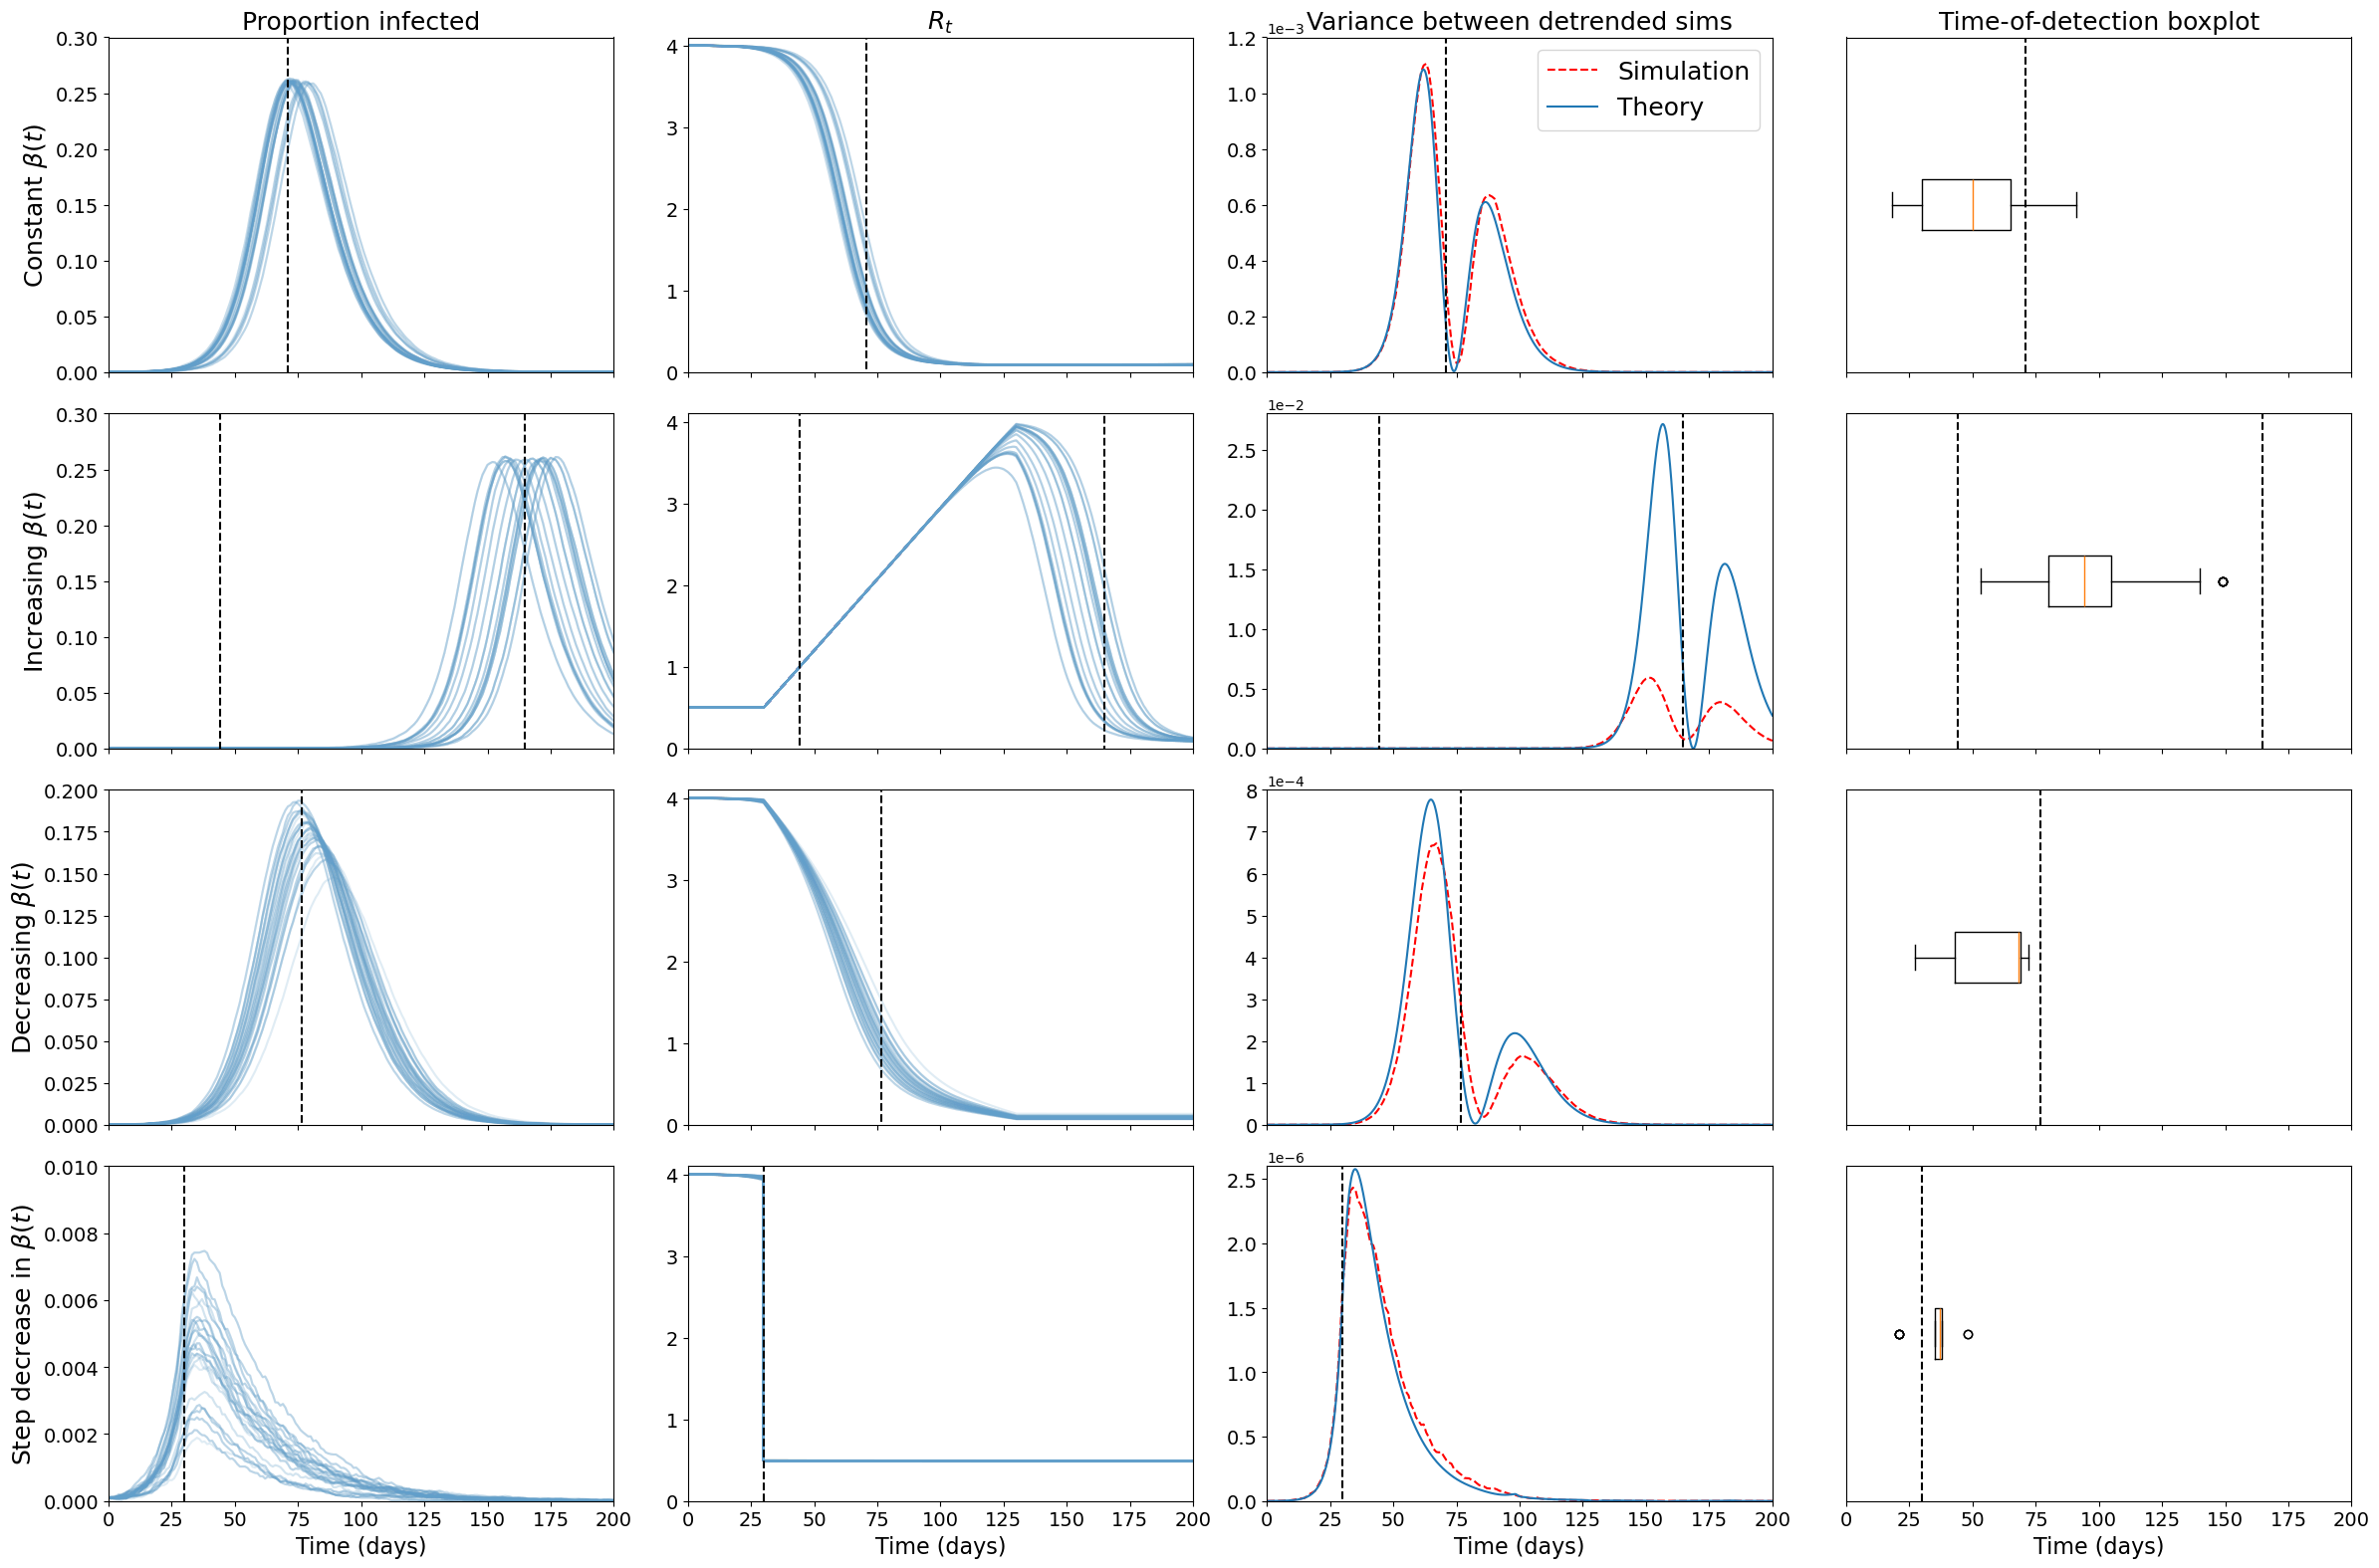

In [54]:
def norm(x):
    rolling_mean = x.expanding().mean()
    rolling_std = x.expanding().std(ddof=0)
    return (x-rolling_mean)/rolling_std

up_lims = [1.2e-3,2.8e-2,8e-4,2.6e-6]
up_lims_p = [0.3,0.3,0.2,0.01]

fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize=(24,16),sharex=True)
for i in range(num_res):
    axs[0,0].plot(days,I_constant[i],color='#629FCA',alpha=0.1)
    axs[0,1].plot(times,Reff_constant[i],color='#629FCA',alpha=0.1)
axs[0,2].plot(days,stoch_cst.var(axis=1).values,linestyle='--',color='r',label='Simulation')
axs[0,2].plot(ts,cst_theory[:,-1],label='Theory')
axs[0,3].boxplot([j for i in times_cst.values() for j in i],vert=False)

axs[0,0].vlines(constant_crit,ymin=axs[0,0].get_yticks()[0],ymax=up_lims_p[0],color='k',linestyle='--')
axs[0,1].vlines(constant_crit,ymin=axs[0,1].get_yticks()[0],ymax=axs[0,1].get_yticks()[-1],color='k',linestyle='--')
axs[0,2].vlines(constant_crit,ymin=axs[0,2].get_yticks()[0],ymax=up_lims[0],color='k',linestyle='--')
axs[0,3].vlines(constant_crit,0.5,1.5,color='k',linestyle='--')

for i in range(num_res):
    axs[1,0].plot(days,I_increasing[i],color='#629FCA',alpha=0.1)
    axs[1,1].plot(times,Reff_increasing[i],color='#629FCA',alpha=0.1)
axs[1,2].plot(days,stoch_inc.var(axis=1).values,linestyle='--',color='r')
axs[1,2].plot(ts,cst_inc[:,-1])
axs[1,3].boxplot([j for i in times_inc.values() for j in i],vert=False)


axs[1,0].vlines(inc_crit_up,ymin=axs[1,0].get_yticks()[0],ymax=up_lims_p[1],color='k',linestyle='--')
axs[1,1].vlines(inc_crit_up,ymin=axs[1,1].get_yticks()[0],ymax=axs[1,1].get_yticks()[-1],color='k',linestyle='--')
axs[1,2].vlines(inc_crit_up,ymin=axs[1,2].get_yticks()[0],ymax=up_lims[1],color='k',linestyle='--')
axs[1,3].vlines(inc_crit_up,0.5,1.5,color='k',linestyle='--')
axs[1,0].vlines(inc_crit_down,ymin=axs[1,0].get_yticks()[0],ymax=up_lims_p[1],color='k',linestyle='--')
axs[1,1].vlines(inc_crit_down,ymin=axs[1,1].get_yticks()[0],ymax=axs[1,1].get_yticks()[-1],color='k',linestyle='--')
axs[1,2].vlines(inc_crit_down,ymin=axs[1,2].get_yticks()[0],ymax=up_lims[1],color='k',linestyle='--')
axs[1,3].vlines(inc_crit_down,0.5,1.5,color='k',linestyle='--')

for i in range(num_res):
    axs[2,0].plot(days,I_decreasing[i],color='#629FCA',alpha=0.1)
    axs[2,1].plot(times,Reff_decreasing[i],color='#629FCA',alpha=0.1)
axs[2,2].plot(days,stoch_dec.var(axis=1).values,linestyle='--',color='r')
axs[2,2].plot(ts,cst_dec[:,-1])
axs[2,3].boxplot([j for i in times_dec.values() for j in i],vert=False)

axs[2,0].vlines(dec_crit,ymin=axs[2,0].get_yticks()[0],ymax=up_lims_p[2],color='k',linestyle='--')
axs[2,1].vlines(dec_crit,ymin=axs[2,1].get_yticks()[0],ymax=axs[2,1].get_yticks()[-1],color='k',linestyle='--')
axs[2,2].vlines(dec_crit,ymin=axs[2,2].get_yticks()[0],ymax=up_lims[2],color='k',linestyle='--')
axs[2,3].vlines(dec_crit,0.5,1.5,color='k',linestyle='--')

for i in range(num_res):
    axs[3,0].plot(days,I_step[i],color='#629FCA',alpha=0.1)
    axs[3,1].plot(times,Reff_step[i],color='#629FCA',alpha=0.1)
axs[3,0].set_xlabel('Time (days)',fontsize=16)
axs[3,1].set_xlabel('Time (days)',fontsize=16)
axs[3,2].plot(days,stoch_step.var(axis=1).values,linestyle='--',color='r')
axs[3,2].plot(ts,cst_step[:,-1])
axs[3,2].set_xlabel('Time (days)',fontsize=16)  
axs[3,3].boxplot([j for i in times_step.values() for j in i],vert=False)
axs[3,3].set_xlabel('Time (days)',fontsize=16)

axs[3,0].vlines(step_crit,ymin=axs[3,0].get_yticks()[0],ymax=up_lims_p[3],color='k',linestyle='--')
axs[3,1].vlines(step_crit,ymin=axs[3,1].get_yticks()[0],ymax=axs[3,1].get_yticks()[-1],color='k',linestyle='--')
axs[3,2].vlines(step_crit,ymin=axs[3,2].get_yticks()[0],ymax=up_lims[3],color='k',linestyle='--')
axs[3,3].vlines(step_crit,0.5,1.5,color='k',linestyle='--')

axs[0,0].set_title('Proportion infected',fontsize=18)
axs[0,1].set_title(r'$R_t$',fontsize=18)
axs[0,2].set_title('Variance between detrended sims',fontsize=18)
axs[0,3].set_title('Time-of-detection boxplot',fontsize=18)

labels= [r'Constant $\beta(t)$',r'Increasing $\beta(t)$', r'Decreasing $\beta(t)$', r'Step decrease in $\beta(t)$']
for i in range(4):
    for j in range(4):
        axs[i,j].tick_params(axis='x', labelsize=14)
        axs[i,j].tick_params(axis='y', labelsize=14)
        if j == 3:
            axs[i,j].set_yticks([])
        if j == 0:
            axs[i,j].set_ylim((0,axs[i,j].get_ylim()[-1]))
        axs[i,j].set_xlim((0,200))
for i in range(4):
    axs[i,0].set_ylim([0,up_lims_p[i]])
    axs[i,1].set_ylim([0,4.1])
    axs[i,2].set_ylim([0,up_lims[i]])
    axs[i,2].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
    axs[i,0].set_ylabel(labels[i],fontsize=18)
axs[0,2].legend(fontsize=18)
plt.tight_layout()
plt.savefig("Figures/simulations_theory.pdf",dpi=2400,bbox_inches='tight')
plt.show()

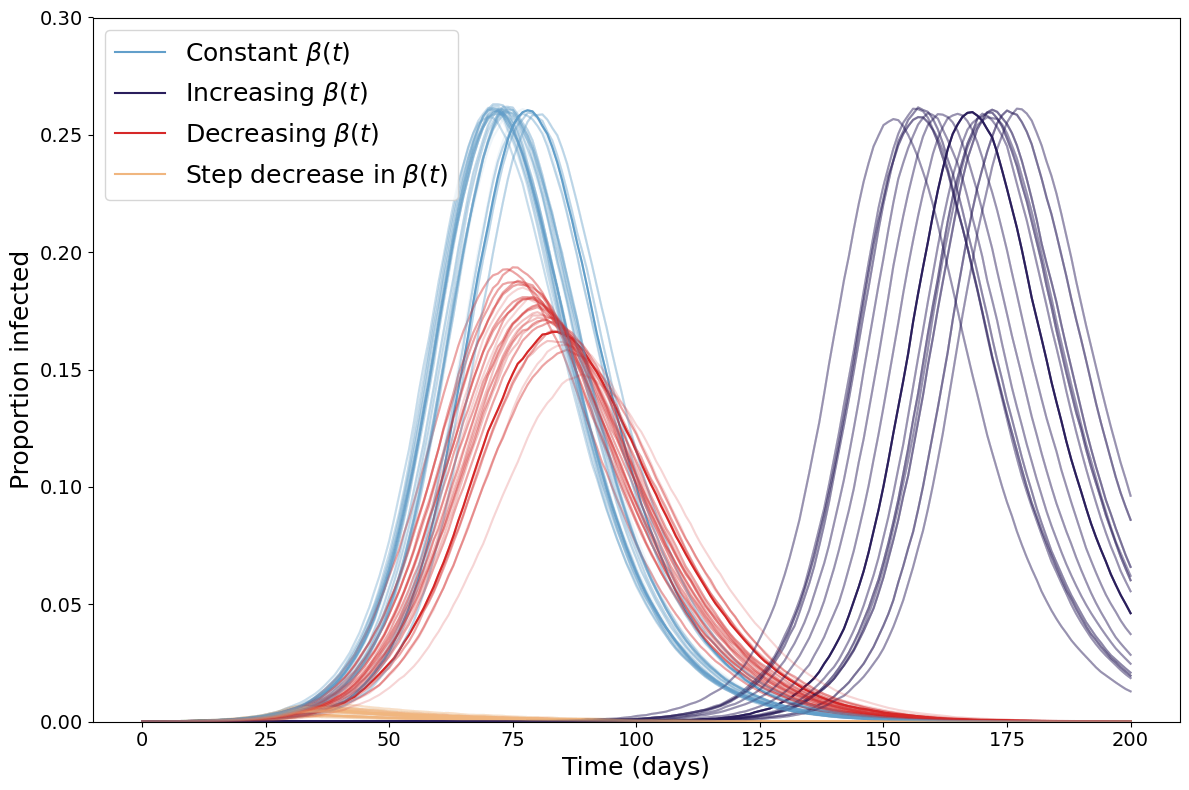

In [62]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(days, I_constant[0], '#629FCA',label=r'Constant $\beta(t)$')
ax.plot(days, I_increasing[0], '#2A1E5C',label=r'Increasing $\beta(t)$')
ax.plot(days, I_decreasing[0], '#D62828',label=r'Decreasing $\beta(t)$')
ax.plot(days, I_step[0], '#F0B67F',label=r'Step decrease in $\beta(t)$')
for i in range(1,100):
    ax.plot(days, I_constant[i], '#629FCA',alpha=0.1,)
    ax.plot(days, I_increasing[i], '#2A1E5C',alpha=0.1)
    ax.plot(days, I_decreasing[i], '#D62828',alpha=0.1)
    ax.plot(days, I_step[i], '#F0B67F',alpha=0.1)
ax.legend(fontsize=18)
ax.set_ylim([0,0.3])
ax.set_ylabel('Proportion infected',fontsize=18)
ax.set_xlabel('Time (days)',fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()
plt.savefig("Figures/alpha_res_agg.pdf",dpi=2400)

In [4]:
# Constant Parameters
N = 1e5  # Total population
delta = 1/5 # Symptom onset rate (1/delta is the infectious)
gamma = 1/10  # Recovery rate (1/gamma is the infectious period)
R_0 = 3.1 # Basic reproduction number estimated for alpha variant
mu = 0.00003424657  # Birth and death rate
initial_infected = 10
initial_exposed = 0
max_time = 200
beta0 = R_0 * (delta+mu)*(gamma+mu)/delta
num_res = 100
print(beta0)

beta_trans = 1 * (delta+mu)*(gamma+mu)/delta
print(beta_trans)

0.31015926472932714
0.10005137571913779


In [7]:
def test_int(X, t, betat, gamma, delta, mu):
    '''
    ODE's for Model 2: SIS with increasing vaccination rate model (elimination by vaccination)
    returns: prevalence mean-field equations (dI/dt), variance of fluctuations (Ivar, d\zeta/dt) and kurtosis of fluctuations (Ikurt)
    RUN: defines if p(t) (rate of vaccine uptake) will be slowing increasing for Ext simulations or fixed for null simulations 
    '''
    S = -betat(t)*X[0]*X[2]-mu*X[0]+mu
    E = betat(t)*X[0]*X[2]-(mu+delta)*X[1]
    I = delta*X[1] - (mu+gamma)*X[2]

    A = np.matrix([[-betat(t)*X[2]-mu, 0, -betat(t)*X[0]], 
                   [betat(t)*X[2],-(delta+mu),betat(t)*X[0]],
                   [0,delta,-(gamma+mu)]])
    B = np.matrix([[betat(t)*X[0]*X[2]+mu*X[0]+mu,-betat(t)*X[0]*X[2],0],
                   [-betat(t)*X[0]*X[2],betat(t)*X[0]*X[2]+(delta+mu)*X[1],-delta*X[1]],
                   [0,-delta*X[1],delta*X[1]+(gamma+mu)*X[2]]])

    Θ = np.matrix([[X[3],X[4],X[5]],
                   [X[4],X[6],X[7]],
                   [X[5],X[7],X[8]]])

    K = A*Θ +Θ*A.transpose()+B/1e5
    return [S, E, I, K[0,0], K[0,1], K[0,2], K[1,1], K[1,2], K[2,2]]

betat = lambda x: 0.310159
p = (0.310159-0.05)/100
tau = 30
def beta_increasing_t(t):
    betat = 0.05+p*(t-tau) if t > tau else 0.05
    if betat >= 0.310159:
        return 0.310159
    else:
        return betat

def beta_decreasing_t(t):
    betat = 0.310159-p*(t-tau) if t > tau else 0.310159
    if betat <= 0.05:
        return 0.05
    else:
        return betat

def beta_step_t(t):
    return 0.310159 if t<tau else 0.05

from scipy.integrate import odeint
ts = np.arange(0,200.1,0.1)
cst_theory = odeint(test_int,[(1e5-10)/1e5,0,10/1e5,0,0,0,0,0,0],ts,args=(betat,1/10,1/5,0.00003424657))
cst_inc = odeint(test_int,[(1e5-10)/1e5,0,10/1e5,0,0,0,0,0,0],ts,args=(beta_increasing_t,1/10,1/5,0.00003424657))
cst_dec = odeint(test_int,[(1e5-10)/1e5,0,10/1e5,0,0,0,0,0,0],ts,args=(beta_decreasing_t,1/10,1/5,0.00003424657))
cst_step = odeint(test_int,[(1e5-10)/1e5,0,10/1e5,0,0,0,0,0,0],ts,args=(beta_step_t,1/10,1/5,0.00003424657))

In [8]:
# Run simulation
def constant_sim(alg):
    return alg(N, beta_constant, delta, gamma, mu, initial_infected, initial_exposed, max_time, beta0)

runs = [gillespie_seir for i in range(num_res)]

with Pool(5) as pool:
    res = pool.map(constant_sim, runs)

times = np.arange(0,max_time+0.1,0.1)
days = np.arange(0,max_time+0.1,1)
I_constant = np.zeros((num_res,len(days)))
Reff_constant = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_constant[i,:] = interp1d(res[i][0],res[i][3],kind='previous',fill_value='extrapolate')(days)/N
    Reff_constant[i,:] = np.interp(times,res[i][0],res[i][1])/N * R_0


# Run simulation
betalow_inc = 0.05
p_inc = (beta0-betalow_inc)/100
tau = 30
def increasing_sim(alg):
    return alg(N, beta_increasing, delta, gamma, mu, initial_infected, initial_exposed, max_time, betalow_inc, p_inc, tau, beta0)

# Run simulation
betalow = 0.05
p_dec = (beta0-betalow)/100
tau_low = 30
def decreasing_sim(alg):
    return alg(N, beta_decreasing, delta, gamma, mu, initial_infected, initial_exposed, max_time, beta0, p_dec, tau_low, betalow)

with Pool(5) as pool:
    res_decreasing = pool.map(decreasing_sim, runs)

I_decreasing = np.zeros((num_res,len(days)))
Reff_decreasing = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_decreasing[i,:] = interp1d(res_decreasing[i][0],res_decreasing[i][3],kind='previous',fill_value='extrapolate')(days)/N
    Reff_decreasing[i,:] = np.interp(times,res_decreasing[i][0],res_decreasing[i][1])/N * delta/((delta+mu)*(gamma+mu))\
        * np.array([beta_decreasing(t,[beta0,p_dec,tau_low,betalow]) for t in times])


# Run simulation
# tau = 30
def step_sim(alg):
    return alg(N, beta_step, delta, gamma, mu, initial_infected, initial_exposed, max_time, beta0, betalow, tau)

with Pool(5) as pool:
    res_step = pool.map(step_sim, runs)

I_step = np.zeros((num_res,len(days)))
Reff_step = np.zeros((num_res,len(times)))
for i in range(num_res):
    I_step[i,:] = interp1d(res_step[i][0],res_step[i][3],kind='previous',fill_value='extrapolate')(days)/N
    Reff_step[i,:] = np.interp(times,res_step[i][0],res_step[i][1]) / N  * delta/((delta+mu)*(gamma+mu))\
        * np.array([beta_step(t,[beta0,betalow,tau]) for t in times])

In [7]:
num_inc = 700
runs_inc = [gillespie_seir for i in range(num_inc)] 

with Pool(5) as pool:
    res_increasing = pool.map(increasing_sim, runs_inc)

I_increasing = np.zeros((num_inc,len(days)))
Reff_increasing = np.zeros((num_inc,len(times)))
for i in range(num_inc):
    I_increasing[i,:] = interp1d(res_increasing[i][0],res_increasing[i][3],kind='previous',fill_value='extrapolate')(days)/N
    Reff_increasing[i,:] = np.interp(times,res_increasing[i][0],res_increasing[i][1])/N * delta/((delta+mu)*(gamma+mu))\
        * np.array([beta_increasing(t,[betalow_inc,p_inc,tau,beta0]) for t in times])
    
drop_list = []
for i in range(np.shape(I_increasing)[0]):
    if Reff_increasing[i,1500] >= 2.95:
        drop_list.append(i)
I_increasing = np.delete(I_increasing, drop_list,axis=0)[:100,:]
Reff_increasing = np.delete(Reff_increasing, drop_list,axis=0)[:100,:]
print(np.shape(I_increasing))
print(times[np.where(np.abs(np.mean(Reff_increasing,axis=0)-1)<=1e-2)])
I_dict = {'cst': I_constant, 'inc': I_increasing, 'dec': I_decreasing, 'step': I_step}
R_dict = {'cst': Reff_constant, 'inc': Reff_increasing, 'dec': Reff_decreasing, 'step': Reff_step}

(100, 201)
[ 48.9  49.   49.1  49.2  49.3  49.4  49.5  49.6 179.2 179.3 179.4]


In [33]:
import pickle
if True:
    with open('wild_I_theory.pkl','wb') as f:
        pickle.dump(I_dict,f)
    with open('wild_R_theory.pkl','wb') as f:
        pickle.dump(R_dict,f)
else:
    with open('wild_I_theory.pkl','rb') as f:
        I_dict = pickle.load(f)
        I_increasing = I_dict['inc']
    with open('wild_R_theory.pkl','rb') as f:
        R_dict = pickle.load(f)
        Reff_increasing = R_dict['inc']
    max_time = 200
    days = np.arange(0,max_time+0.1,1)
    times = np.arange(0,max_time+0.1,0.1)
    tau = 30

In [26]:
import pickle
if False:
    with open('wild_I_theory.pkl','wb') as f:
        pickle.dump(I_dict,f)
    with open('wild_R_theory.pkl','wb') as f:
        pickle.dump(R_dict,f)
else:
    with open('wild_I_theory.pkl','rb') as f:
        I_dict = pickle.load(f)
        I_constant = I_dict['cst']
        I_increasing = I_dict['inc']
        I_decreasing = I_dict['dec']
        I_step = I_dict['step']
    with open('wild_R_theory.pkl','rb') as f:
        R_dict = pickle.load(f)
        Reff_constant = R_dict['cst']
        Reff_increasing = R_dict['inc']
        Reff_decreasing = R_dict['dec']
        Reff_step = R_dict['step']
    max_time = 200
    days = np.arange(0,max_time+0.1,1)
    times = np.arange(0,max_time+0.1,0.1)
    tau = 30

In [29]:
# Get detect indices for timeline
constant_crit = np.mean(times[np.where(np.abs(np.mean(Reff_constant,axis=0)-1)<=1e-2)])
inc_crit_up = np.mean(times[np.where(np.abs(np.mean(Reff_increasing,axis=0)-1)<=1e-2)][:8])
inc_crit_down = np.mean(times[np.where(np.abs(np.mean(Reff_increasing,axis=0)-1)<=1e-2)][8:])
dec_crit = np.mean(times[np.where(np.abs(np.mean(Reff_decreasing,axis=0)-1)<=1e-2)])
step_crit = tau
df = pd.DataFrame(I_constant).T
stoch_cst = df.sub(df.mean(axis = 1), axis = 'rows')
df_step = pd.DataFrame(I_step).T
stoch_step = df_step.sub(df_step.mean(axis = 1), axis = 'rows')
df_increasing = pd.DataFrame(I_increasing).T
stoch_inc = df_increasing.sub(df_increasing.mean(axis = 1), axis = 'rows')
df_decreasing = pd.DataFrame(I_decreasing).T
stoch_dec = df_decreasing.sub(df_decreasing.mean(axis = 1), axis = 'rows')

# Function to normalise EWS for 2-sigma calculations
def pandas_zscore(dataframe):
    rolling_mean = dataframe.expanding().mean()
    rolling_std = dataframe.expanding().std(ddof=0)
    normalise_stats = (dataframe - rolling_mean)/rolling_std
    return normalise_stats

# Function to calculate EWS on a rolling window for each column
def calculate_ews_rolling(wide_data, window_size):
    ews_data = {}
    rolling = wide_data.rolling(window=window_size,center=False, min_periods=1)
    # variance = (wide_data**2).rolling(window=window_size,center=False, min_periods=1).mean()
    variance = rolling.var()
    ews_data['variance'] = variance
    normalised_ews_data = {}
    for ews in ews_data.keys():
        normalised_ews_data[ews] = pandas_zscore(ews_data[ews])
    return ews_data, normalised_ews_data

cst, cst_norm = calculate_ews_rolling(stoch_cst, 7)
inc, inc_norm = calculate_ews_rolling(stoch_inc, 7)
dec, dec_norm = calculate_ews_rolling(stoch_dec, 7)
step, step_norm = calculate_ews_rolling(stoch_step, 7)
def long_run_averages(standardised):
    n = len(standardised)
    running_mean = np.zeros(n)
    running_std= np.zeros(n)
    for j in range(n):
        running_mean[j] = np.nanmean(standardised[1:j+1])
        running_std[j] = np.nanstd(standardised[1:j+1])
    return running_std, running_mean

def exceed_threshold_cutoffs(stat_timeseries, ltla):
    std_val = []
    mean_val = []
    running_std, running_mean = long_run_averages(stat_timeseries[ltla].values)
    std_val = np.concatenate((std_val,running_std))
    mean_val = np.concatenate((mean_val,running_mean))
    # Get indices where stat > mean + 2*sigma and indices where stat < mean - 2*sigma
    stat_timeseries = stat_timeseries[ltla].values
    indices_greater = [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])>(mean_val+2*std_val)[i] ]
    indices_smaller =  [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])<(mean_val-2*std_val)[i] ]
    all_indices = np.setdiff1d(np.unique(indices_greater + indices_smaller ),[1])    
    return all_indices,mean_val,std_val
    
def loop_EWSs_store_results_cutoffs(ews_dict, ltlas):
    indices_dict = {}
    mean_dict = {}
    std_dict = {}
    for stat in ews_dict.keys():
        indices_dict[stat] = {}
        mean_dict[stat] = {}
        std_dict[stat] = {}
        for ltla in ltlas:
            stat_data = ews_dict[stat][ltla].reset_index()
            indices, mean_val, std_val = exceed_threshold_cutoffs(stat_data, ltla)
            indices_dict[stat][ltla] = indices
            mean_dict[stat][ltla] = mean_val
            std_dict[stat][ltla] = std_val
    return indices_dict, mean_dict, std_dict


ind_cst, mean_cst, std_cst = loop_EWSs_store_results_cutoffs(cst_norm,np.arange(len(I_constant)))
ind_inc, mean_inc, std_inc = loop_EWSs_store_results_cutoffs(inc_norm,np.arange(len(I_increasing)))
ind_dec, mean_dec, std_dec = loop_EWSs_store_results_cutoffs(dec_norm,np.arange(len(I_decreasing)))
ind_step, mean_step, std_step = loop_EWSs_store_results_cutoffs(step_norm,np.arange(len(I_step)))

# Get detect indices for timeline
from operator import itemgetter

def detect(arr, times, n):
    if len(arr) < n:
        return []
    time = []
    values = []
    i = 0
    while i < len(arr) - (n - 1):
        if all(arr[i + j] + 1 == arr[i + j + 1] for j in range(n - 1)):
            values.append(arr[i + n - 1])
            time.append(times[arr[i + n -1]])
            # Skip to the end of this sequence of consecutive numbers
            while i + n - 1 < len(arr) - 1 and arr[i + n - 1] + 1 == arr[i + n]:
                i += 1
        i += 1
    return time


times_cst = {}
times_inc = {}
times_dec = {}
times_step = {}

for sim in np.arange(100):
    times_cst[sim] = detect(ind_cst['variance'][sim],days,3)
    times_inc[sim] = detect(ind_inc['variance'][sim],days,3)
    times_dec[sim] = detect(ind_dec['variance'][sim],days,3)
    times_step[sim] = detect(ind_step['variance'][sim],days,3)

/tmp/ipykernel_195091/3251638616.py:44: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_195091/3251638616.py:44: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_195091/3251638616.py:44: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtyp

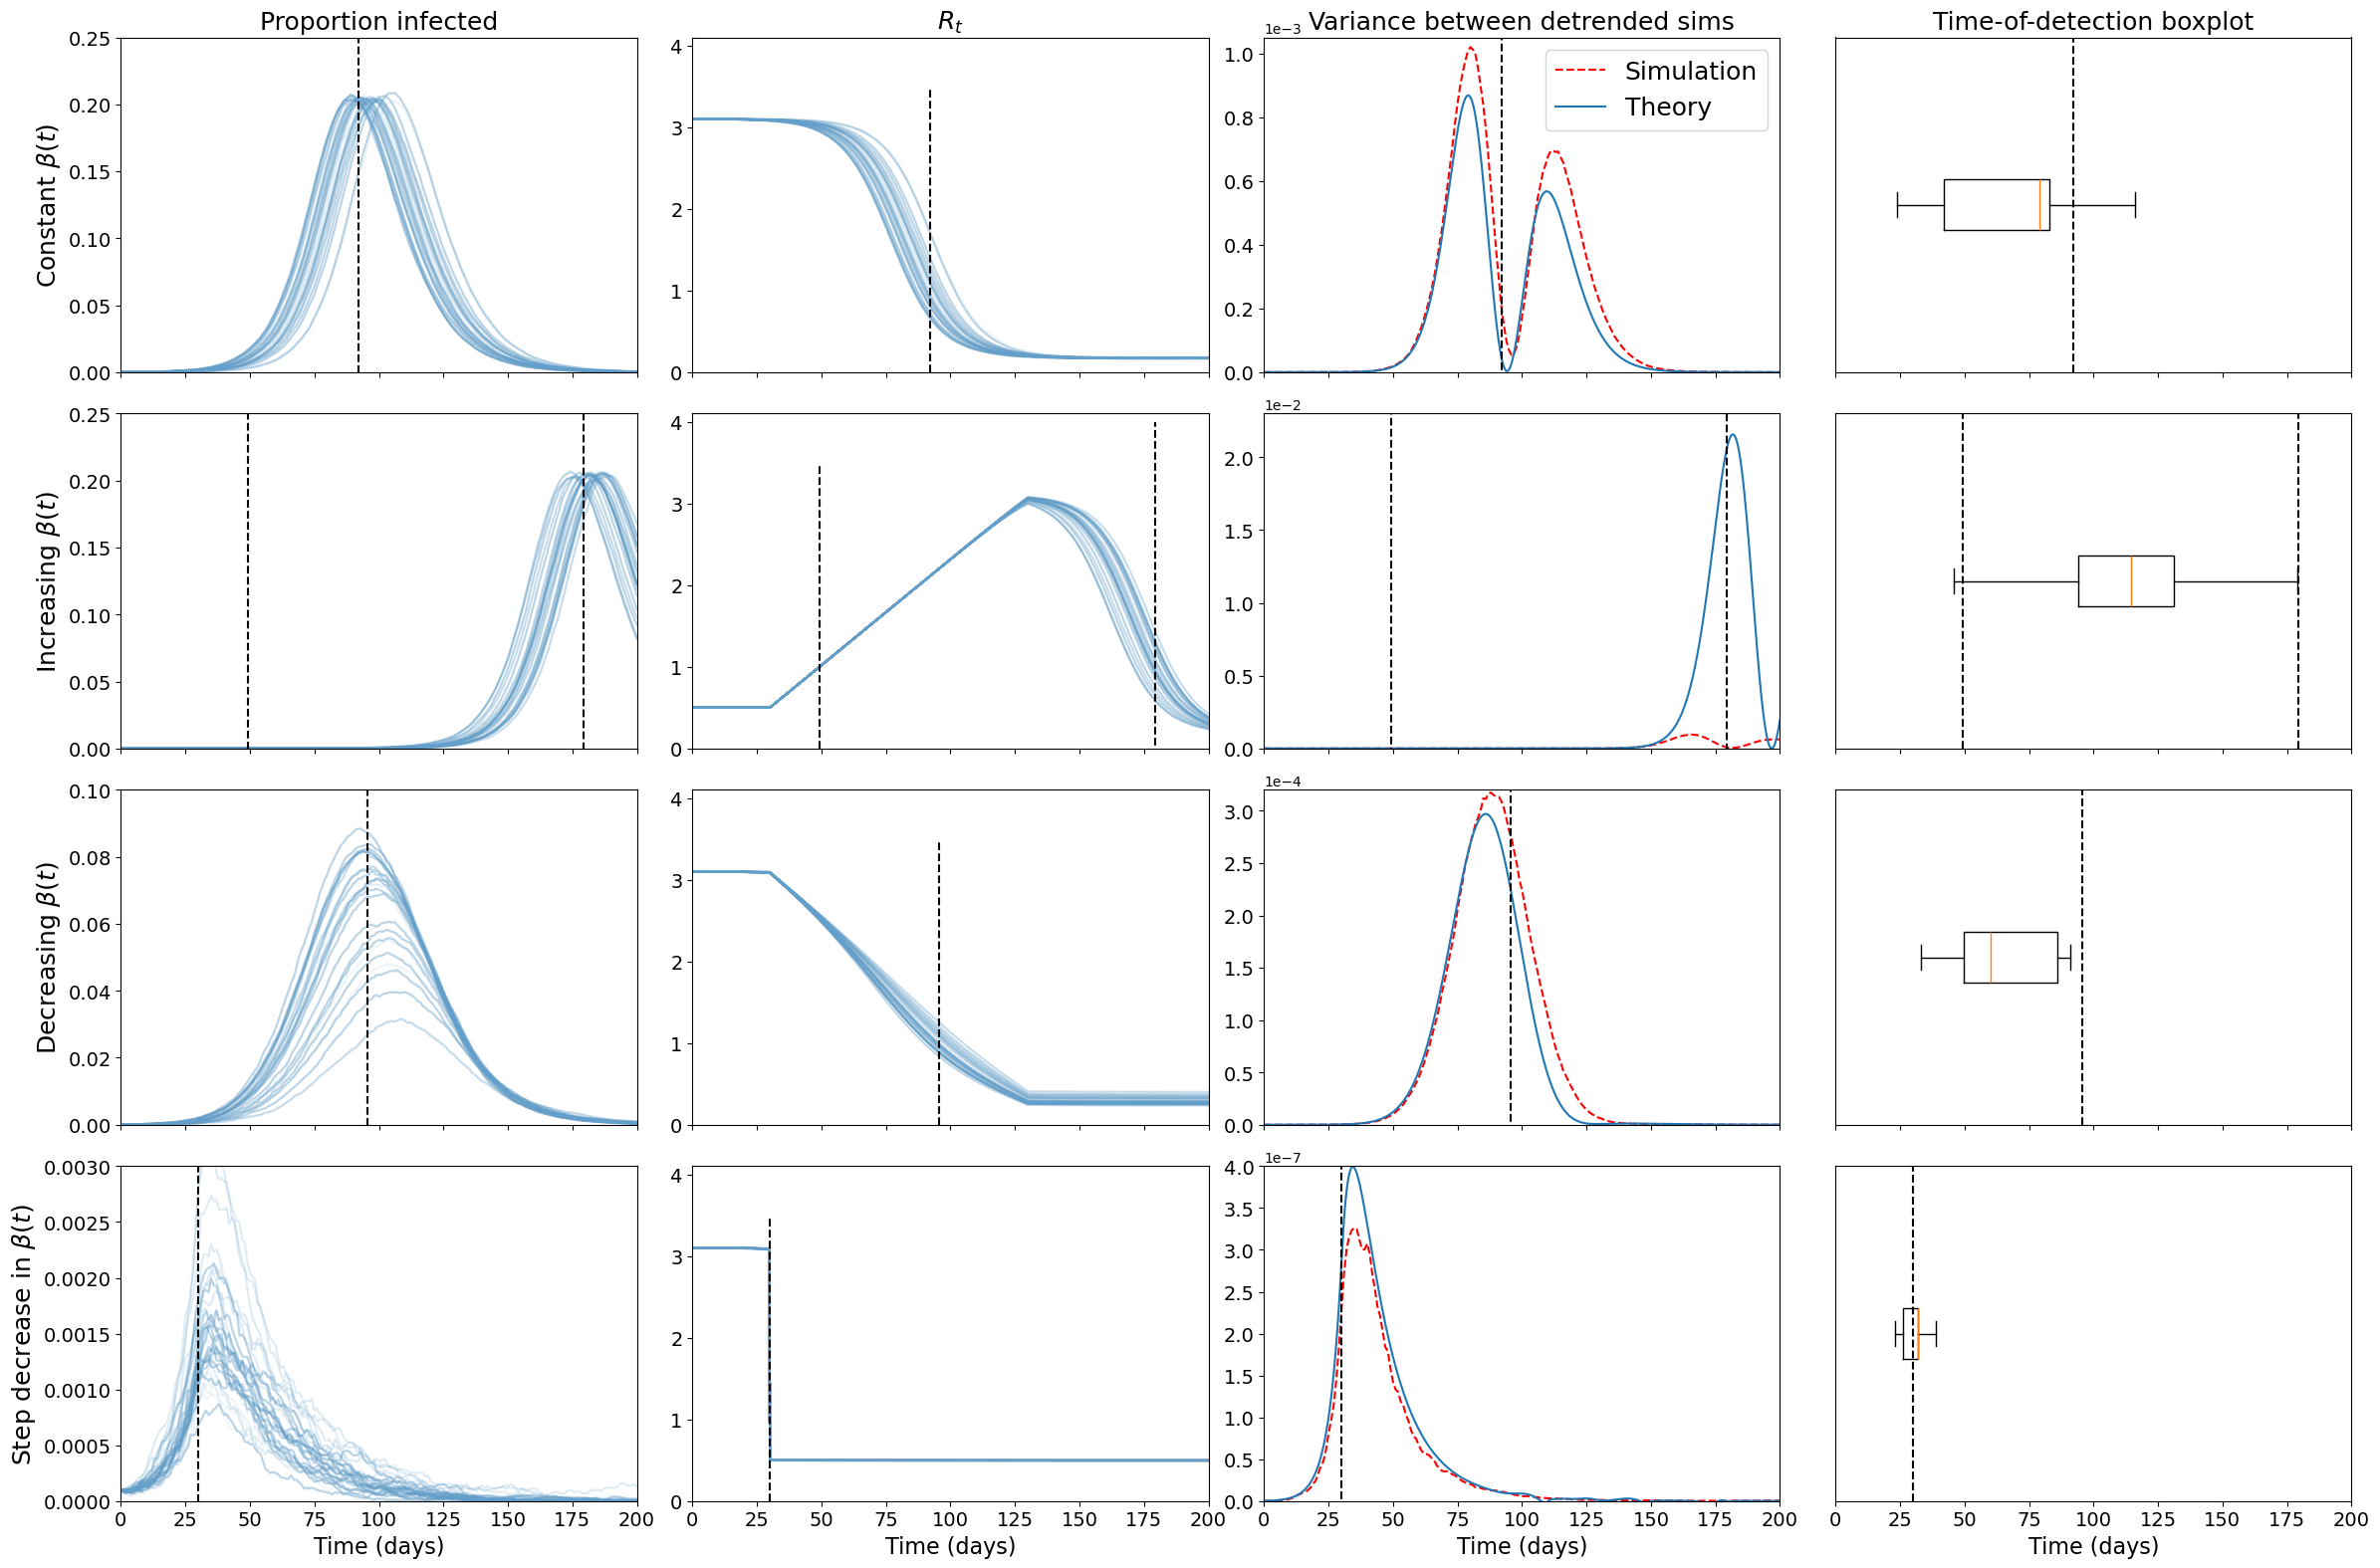

In [40]:
def norm(x):
    rolling_mean = x.expanding().mean()
    rolling_std = x.expanding().std(ddof=0)
    return (x-rolling_mean)/rolling_std

up_lims = [1.05e-3,2.3e-2,3.2e-4,4e-7]
up_lims_p = [0.25,0.25,0.1,0.003]

fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize=(24,16),sharex=True)
for i in range(num_res):
    axs[0,0].plot(days,I_constant[i],color='#629FCA',alpha=0.1)
    axs[0,1].plot(times,Reff_constant[i],color='#629FCA',alpha=0.1)
axs[0,2].plot(days,stoch_cst.var(axis=1).values,linestyle='--',color='r',label='Simulation')
axs[0,2].plot(ts,cst_theory[:,-1],label='Theory')
axs[0,3].boxplot([j for i in times_cst.values() for j in i],vert=False)

axs[0,0].vlines(constant_crit,ymin=axs[0,0].get_yticks()[0],ymax=up_lims_p[0],color='k',linestyle='--')
axs[0,1].vlines(constant_crit,ymin=axs[0,1].get_yticks()[0],ymax=axs[0,1].get_yticks()[-1],color='k',linestyle='--')
axs[0,2].vlines(constant_crit,ymin=axs[0,2].get_yticks()[0],ymax=up_lims[0],color='k',linestyle='--')
axs[0,3].vlines(constant_crit,0.5,1.5,color='k',linestyle='--')

for i in range(num_res):
    axs[1,0].plot(days,I_increasing[i],color='#629FCA',alpha=0.1)
    axs[1,1].plot(times,Reff_increasing[i],color='#629FCA',alpha=0.1)
axs[1,2].plot(days,stoch_inc.var(axis=1).values,linestyle='--',color='r')
axs[1,2].plot(ts,cst_inc[:,-1])
axs[1,3].boxplot([j for i in times_inc.values() for j in i],vert=False)


axs[1,0].vlines(inc_crit_up,ymin=axs[1,0].get_yticks()[0],ymax=up_lims_p[1],color='k',linestyle='--')
axs[1,1].vlines(inc_crit_up,ymin=axs[1,1].get_yticks()[0],ymax=axs[1,1].get_yticks()[-1],color='k',linestyle='--')
axs[1,2].vlines(inc_crit_up,ymin=axs[1,2].get_yticks()[0],ymax=up_lims[1],color='k',linestyle='--')
axs[1,3].vlines(inc_crit_up,0.5,1.5,color='k',linestyle='--')
axs[1,0].vlines(inc_crit_down,ymin=axs[1,0].get_yticks()[0],ymax=up_lims_p[1],color='k',linestyle='--')
axs[1,1].vlines(inc_crit_down,ymin=axs[1,1].get_yticks()[0],ymax=axs[1,1].get_yticks()[-1],color='k',linestyle='--')
axs[1,2].vlines(inc_crit_down,ymin=axs[1,2].get_yticks()[0],ymax=up_lims[1],color='k',linestyle='--')
axs[1,3].vlines(inc_crit_down,0.5,1.5,color='k',linestyle='--')

for i in range(num_res):
    axs[2,0].plot(days,I_decreasing[i],color='#629FCA',alpha=0.1)
    axs[2,1].plot(times,Reff_decreasing[i],color='#629FCA',alpha=0.1)
axs[2,2].plot(days,stoch_dec.var(axis=1).values,linestyle='--',color='r')
axs[2,2].plot(ts,cst_dec[:,-1])
axs[2,3].boxplot([j for i in times_dec.values() for j in i],vert=False)

axs[2,0].vlines(dec_crit,ymin=axs[2,0].get_yticks()[0],ymax=up_lims_p[2],color='k',linestyle='--')
axs[2,1].vlines(dec_crit,ymin=axs[2,1].get_yticks()[0],ymax=axs[2,1].get_yticks()[-1],color='k',linestyle='--')
axs[2,2].vlines(dec_crit,ymin=axs[2,2].get_yticks()[0],ymax=up_lims[2],color='k',linestyle='--')
axs[2,3].vlines(dec_crit,0.5,1.5,color='k',linestyle='--')

for i in range(num_res):
    axs[3,0].plot(days,I_step[i],color='#629FCA',alpha=0.1)
    axs[3,1].plot(times,Reff_step[i],color='#629FCA',alpha=0.1)
axs[3,0].set_xlabel('Time (days)',fontsize=16)
axs[3,1].set_xlabel('Time (days)',fontsize=16)
axs[3,2].plot(days,stoch_step.var(axis=1).values,linestyle='--',color='r')
axs[3,2].plot(ts,cst_step[:,-1])
axs[3,2].set_xlabel('Time (days)',fontsize=16)  
axs[3,3].boxplot([j for i in times_step.values() for j in i],vert=False)
axs[3,3].set_xlabel('Time (days)',fontsize=16)

axs[3,0].vlines(step_crit,ymin=axs[3,0].get_yticks()[0],ymax=up_lims_p[3],color='k',linestyle='--')
axs[3,1].vlines(step_crit,ymin=axs[3,1].get_yticks()[0],ymax=axs[3,1].get_yticks()[-1],color='k',linestyle='--')
axs[3,2].vlines(step_crit,ymin=axs[3,2].get_yticks()[0],ymax=up_lims[3],color='k',linestyle='--')
axs[3,3].vlines(step_crit,0.5,1.5,color='k',linestyle='--')

axs[0,0].set_title('Proportion infected',fontsize=18)
axs[0,1].set_title(r'$R_t$',fontsize=18)
axs[0,2].set_title('Variance between detrended sims',fontsize=18)
axs[0,3].set_title('Time-of-detection boxplot',fontsize=18)

labels= [r'Constant $\beta(t)$',r'Increasing $\beta(t)$', r'Decreasing $\beta(t)$', r'Step decrease in $\beta(t)$']
for i in range(4):
    for j in range(4):
        axs[i,j].tick_params(axis='x', labelsize=14)
        axs[i,j].tick_params(axis='y', labelsize=14)
        if j == 3:
            axs[i,j].set_yticks([])
        if j == 0:
            axs[i,j].set_ylim((0,axs[i,j].get_ylim()[-1]))
        axs[i,j].set_xlim((0,200))
for i in range(4):
    axs[i,0].set_ylim([0,up_lims_p[i]])
    axs[i,1].set_ylim([0,4.1])
    axs[i,2].set_ylim([0,up_lims[i]])
    axs[i,2].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
    axs[i,0].set_ylabel(labels[i],fontsize=18)
axs[0,2].legend(fontsize=18)
plt.tight_layout()
plt.savefig("Figures/simulations_wildtype_theory.pdf",dpi=2400,bbox_inches='tight')
plt.show()

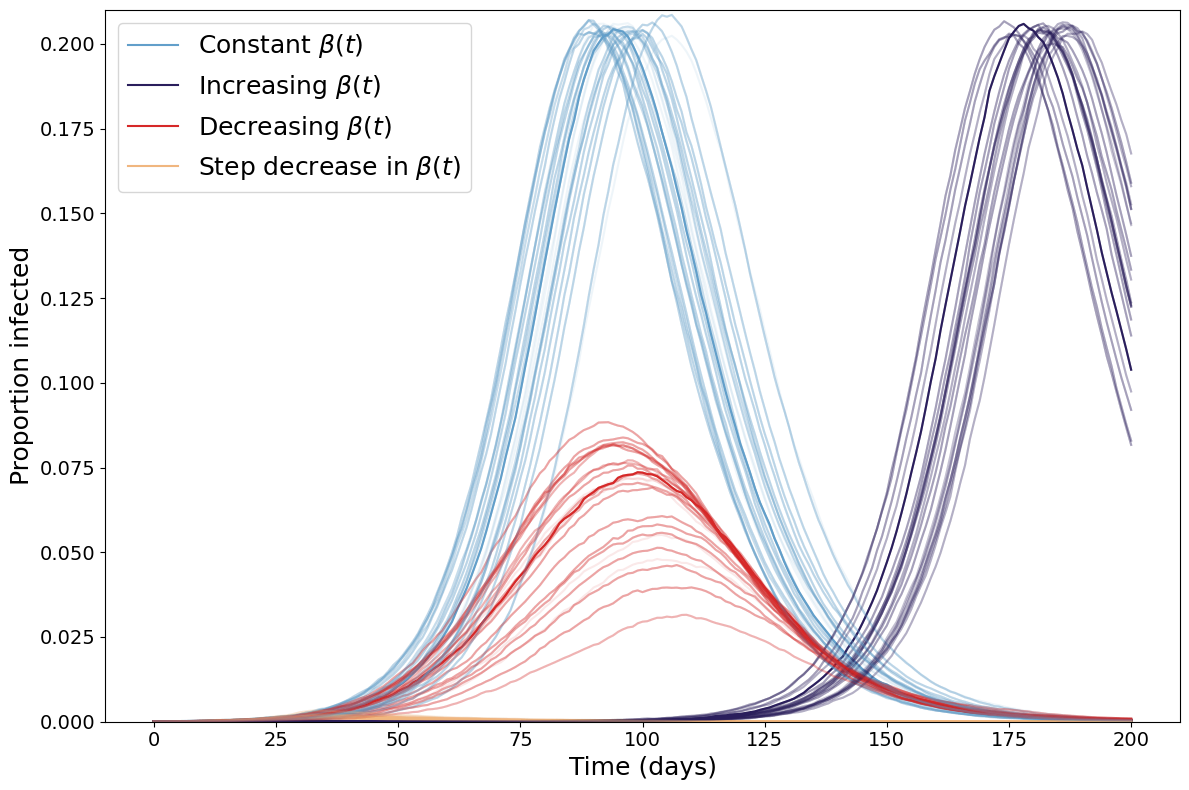

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(days, I_constant[0], '#629FCA',label=r'Constant $\beta(t)$')
ax.plot(days, I_increasing[0], '#2A1E5C',label=r'Increasing $\beta(t)$')
ax.plot(days, I_decreasing[0], '#D62828',label=r'Decreasing $\beta(t)$')
ax.plot(days, I_step[0], '#F0B67F',label=r'Step decrease in $\beta(t)$')
for i in range(1,100):
    ax.plot(days, I_constant[i], '#629FCA',alpha=0.1,)
    ax.plot(days, I_increasing[i], '#2A1E5C',alpha=0.1)
    ax.plot(days, I_decreasing[i], '#D62828',alpha=0.1)
    ax.plot(days, I_step[i], '#F0B67F',alpha=0.1)
ax.legend(fontsize=18)
ax.set_ylim([0,0.21])
ax.set_ylabel('Proportion infected',fontsize=18)
ax.set_xlabel('Time (days)',fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()
plt.savefig("Figures/wildtype_res_theory.pdf",dpi=2400)